In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# TRAINING ON TEST DATA: REMOVING NEAR-DUPLICATES IN FASHION-MNIST

-----
## Parte 1: Carga y limpieza de los datos
-----

## Extrayendo los datos de la base de datos original

Para las bases de datos de tipo NMINST se tienen 4 archivos, dos para entrenamiento y dos para pruebas. Uno de los archivos pertenece a los registros o imagenes codificadas por pixeles y el otro archivo pertenece a la etiqueta de cada registro. Cada uno de estos archivos está codificado en hexadecimal o base 16, es decir se tiene una formato como el siguiente:
```
\x00 representa el 0 base 10
\xea\x4c representa el 234 base 10,76
```
Estos archivos tienen caracteres como estos y es por eso que debemos extraer de una manera adecuada estos datos y convertirlos para poder representar a cada una de las imágenes y sus eqtiquetas

### Fashion-MNIST y MNIST

Para el entrenamiento y para las pruebas se tienen dos archivos respectivamente, uno con la representacion de las imágenes y otro con la etiqueta de la imagen. Para esto debemos extraer los datos de los archivos originales y almacenar cada imagen como una fila de cada uno de sus pixeles. En este caso se está trabajando con imagenes de 28x28 pixeles, por lo que al final se obtienen arreglos de 784 valores en línea. Una forma de almacenar estos datos convertidos es en un formato csv, los cuales se pueden cargar facilmente a python

El proceso para realizar la conversión de estos archivos se puede ver en el siguiente algoritmo. Esto es genérico para el caso de Fashion-MNIST y MNIST. Se ha seguido el procedimiento presentado por [pjreddie][pjreddie_page]

[pjreddie_page]: https://pjreddie.com/projects/mnist-in-csv/

In [ ]:
def convert(img_file, label_file, out_file, n):
    f = open(img_file, "rb") # Archivo con los datos de las imágenes
    l = open(label_file, "rb") # Archivo con las etiquetas
    o = open(out_file, "w") # Archivo donde se almacenan los registros convertidos
    
    f.read(16)
    l.read(8)
    images = []

    for i in range(n):
        image = [ord(l.read(1))] # capturamos la i-ésima etiqueta
        for j in range(28*28):
            image.append(ord(f.read(1))) # Capturamos el j-ésimo pixel de la j-ésima imágen
        images.append(image)

    for image in images:
        o.write(",".join(str(pix) for pix in image)+"\n") # Agregamos cada pixel de cada imagen en el formato csv
    f.close()
    o.close()
    l.close()

Primero convertimos el Fashion-MNIST para entrenamiento y testeo

In [ ]:
%%time
# Convertimos los datos de entrenamiento
convert(
    img_file = "datasets/fashion-MNIST/train-images-idx3-ubyte",
    label_file = "datasets/fashion-MNIST/train-labels-idx1-ubyte",
    out_file = "datasets/fashion-MNIST/fashion_MNIST_train.csv",
    n = 60000
)

# Convertimos los datos de prueba
convert(
    img_file = "datasets/fashion-MNIST/t10k-images-idx3-ubyte",
    label_file = "datasets/fashion-MNIST/t10k-labels-idx1-ubyte",
    out_file = "datasets/fashion-MNIST/fashion_MNIST_test.csv",
    n = 10000
)

Luego convertimos el MNIST para entrenamiento y testeo

In [ ]:
%%time
# Convertimos los datos de entrenamiento
convert(
    img_file = "datasets/mnist/train-images-idx3-ubyte",
    label_file = "datasets/mnist/train-labels-idx1-ubyte",
    out_file = "datasets/mnist/MNIST_train.csv",
    n = 60000
)

# Convertimos los datos de prueba
convert(
    img_file = "datasets/mnist/t10k-images-idx3-ubyte",
    label_file = "datasets/mnist/t10k-labels-idx1-ubyte",
    out_file = "datasets/mnist/MNIST_test.csv",
    n = 10000
)

Generados los archivos csv, procedemos a cargarlos

In [ ]:
data_f_mnist = pd.read_csv("datasets/fashion-MNIST/fashion_MNIST_train.csv")
test_f_mnist = pd.read_csv("datasets/fashion-MNIST/fashion_MNIST_test.csv")
data_f_mnist.shape, test_f_mnist.shape

In [ ]:
data_mnist = pd.read_csv("datasets/mnist/MNIST_train.csv")
test_mnist = pd.read_csv("datasets/mnist/MNIST_test.csv")
data_mnist.shape, test_mnist.shape

Renombramos las columnas de modo que tengan un formato especifco. La primer columna acumula las etiquetas o clases de cada registro. las demas 784 columnas son cada uno de los pixeles de la imagen de 28X28 donde se hace un barrido horizontal de derecha hacia izquierda y vertical de arriba hacia abajo

In [ ]:
data_f_mnist.columns = ['label']+[f'px{i}' for i in range(1,785)]
data_mnist.columns = ['label']+[f'px{i}' for i in range(1,785)]
data_f_mnist.head()

In [ ]:
data_mnist.head()

In [ ]:
test_f_mnist.columns = ['label']+[f'px{i}' for i in range(1,785)]
test_mnist.columns = ['label']+[f'px{i}' for i in range(1,785)]
test_f_mnist.head()

In [ ]:
test_f_mnist.head()

-----
## Parte 2 Creando modelos de aprendizaje
-----

En esta sección vamos a trabajar sobre los datasets MNIST y Fasion-MNIST. Realmente el proceso presentado en este artículo está pensado para trabajar con cualquier tipo de base de datos relacionado con imagenes. La idea es encontrar las imagenes del conjunto de datos de pruebas que tengan una semejanza con imagenes del conjunto de datos de entrenamiento y eliminarla. Las condiciones de semejanza son las siguientes:
- __Tamaño y forma:__ la imagen total debe coincidir con 10 píxeles o menos
- __Esquema:__ Alias alrededor del artículo de ropa es 90% similar
- __Tono:__ la diferencia de color es indistinguible de un vistazo
- __Features:__ Vary by 1 feature such as buttons, zippers, patterns, or text

Se usará una Red Neuronal Convolucional (CNN) para identificar imagenes similares.
La implementación se hará basados en el proceso presentado por [Orhan Gazi Yalçın](https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d), en [Image Classification in 10 Minutes with MNIST Dataset](https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d)

-----

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

Importamos los datasets de MNIST y Fashion-MNIST

In [2]:
(X_mnist_train, y_mnist_train), (X_mnist_test, y_mnist_test) = tf.keras.datasets.mnist.load_data()
(X_f_mnist_train, y_f_mnist_train), (X_f_mnist_test, y_f_mnist_test) = tf.keras.datasets.fashion_mnist.load_data()
#(x_f_f_mnist_train, y_f_f_mnist_train), (x_f_f_mnist_test, y_f_f_mnist_test) = tf.keras.datasets.fair_fashion_mnist.load_data()

Mostramos la forma de los registros que se contienen en cada dataset

- Para MNIST

Label: 2


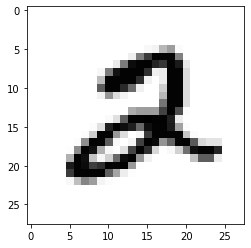

In [3]:
image_index = 5 # You may select anything up to 60,000
print(f"Label: {y_mnist_train[image_index]}")
plt.imshow(X_mnist_train[image_index], cmap='Greys')

- Para Fashion-MNIST

In [4]:
image_index = 500 # You may select anything up to 60,000
print(f"Label: {y_f_mnist_train[image_index]}")
plt.imshow(X_f_mnist_train[image_index], cmap='Greys')

Label: 3


In [5]:
X_mnist_train.shape, y_mnist_train.shape

((60000, 28, 28), (60000,))

Debemos dar el formato adecuado a nuestro conjunto de datos para poder trabajar con una CNN. Por ahora tenemos 60000 registros en entrenamiento y 10000 registros para pruebas en cada conjunto de datos. Cada uno de los registros de entrenamiento es una matriz de 28 X 28, que representa las dimensiones de los pixeles en grayscale

- Para MNIST

In [6]:
# Reshaping the array to 4-dims so that it can work with the Keras API
X_mnist_train = X_mnist_train.reshape(X_mnist_train.shape[0], 28, 28, 1)
X_mnist_test = X_mnist_test.reshape(X_mnist_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

# Making sure that the values are float so that we can get decimal points after division
X_mnist_train = X_mnist_train.astype('float32')
X_mnist_test = X_mnist_test.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
X_mnist_train /= 255
X_mnist_test /= 255

print('X_mnist_train shape:', X_mnist_train.shape)
print('Number of images in X_mnist_train', X_mnist_train.shape[0])
print('Number of images in X_mnist_test', X_mnist_test.shape[0])

X_mnist_train shape: (60000, 28, 28, 1)
Number of images in X_mnist_train 60000
Number of images in X_mnist_test 10000


- Para Fashion-MNIST

In [7]:
# Reshaping the array to 4-dims so that it can work with the Keras API
X_f_mnist_train = X_f_mnist_train.reshape(X_f_mnist_train.shape[0], 28, 28, 1)
X_f_mnist_test = X_f_mnist_test.reshape(X_f_mnist_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

# Making sure that the values are float so that we can get decimal points after division
X_f_mnist_train = X_f_mnist_train.astype('float32')
X_f_mnist_test = X_f_mnist_test.astype('float32')

# Normalizing the RGB codes by dividing it to the max RGB value.
X_f_mnist_train /= 255
X_f_mnist_test /= 255

print('X_f_mnist_train shape:', X_f_mnist_train.shape)
print('Number of images in X_f_mnist_train', X_f_mnist_train.shape[0])
print('Number of images in X_f_mnist_test', X_f_mnist_test.shape[0])

X_f_mnist_train shape: (60000, 28, 28, 1)
Number of images in X_f_mnist_train 60000
Number of images in X_f_mnist_test 10000


In [8]:
X_mnist_train.shape

(60000, 28, 28, 1)

Antes de comenzar a realizar la construcción de la CNN debemos elegis una parte de los datos de entrenamiento para hacer pruebas en el entrenamiento y determinar como está el modelo. Vamos a elegir el 25% de los datos de entrenamiento para pruebas en entrenamiento.

- Para MNIST

In [9]:
X_mnist_train_tr, X_mnist_train_ts, y_mnist_train_tr, y_mnist_train_ts = train_test_split(X_mnist_train,
                                                                                  y_mnist_train,
                                                                                  test_size = 0.20,
                                                                                  random_state = 42
                                                                                 )
print(X_mnist_train_tr.shape)
print(X_mnist_train_ts.shape )
print(y_mnist_train_tr.shape)
print(y_mnist_train_ts.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(48000,)
(12000,)


- Para F-MNIST

In [10]:
X_f_mnist_train_tr, X_f_mnist_train_ts, y_f_mnist_train_tr, y_f_mnist_train_ts = train_test_split(X_f_mnist_train,
                                                                                  y_f_mnist_train,
                                                                                  test_size = 0.20,
                                                                                  random_state = 42
                                                                                 )
print(X_f_mnist_train_tr.shape)
print(X_f_mnist_train_ts.shape )
print(y_f_mnist_train_tr.shape)
print(y_f_mnist_train_ts.shape)

(48000, 28, 28, 1)
(12000, 28, 28, 1)
(48000,)
(12000,)


Las CNN fueron construidas con la siguiente arquitectura:
- 3 capas de convolución
- 1 batch normalization
- 1 Maxpooling
- 1 dropout

```python
# Creating a Sequential Model and adding the layers
model_mnist = Sequential()
model_mnist.add(Conv2D(28, kernel_size = (3, 3), input_shape = input_shape))
model_mnist.add(Conv2D(28, kernel_size = (3, 3)))
model_mnist.add(Conv2D(28, kernel_size = (3, 3)))
model_mnist.add(BatchNormalization())
model_mnist.add(MaxPooling2D(pool_size = (2, 2)))
# model_mnist.add(Flatten()) # Flattening the 2D arrays for fully connected layers
# model_mnist.add(Dense(128, activation = tf.nn.relu))
model_mnist.add(Dropout(0.2))
model_mnist.add(Dense(10, activation = tf.nn.softmax))
#BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, =None, beta_constraint=None, gamma_constraint=None)
```

In [11]:
def create_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.BatchNormalization(input_shape = input_shape))
    model.add(tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape = input_shape))
    model.add(tf.keras.layers.Conv2D(128, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.BatchNormalization(input_shape = input_shape))
    model.add(tf.keras.layers.Conv2D(256, (5, 5), padding='same', activation='elu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256))
    model.add(tf.keras.layers.Activation('elu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10))
    model.add(tf.keras.layers.Activation('softmax'))
    return model

In [12]:
# Creating a Sequential Model for MNIST
model_mnist = create_model()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [13]:
# Creating a Sequential Model for F-MNIST
model_f_mnist = create_model()

Compilamos nuestros modelos

In [14]:
#sgd = SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
#rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
#adam = Adam(lr = 1e-3,
#            beta_1 = 0.9,
#            beta_2=0.999,
#            epsilon=None,
#            decay=0.0,
#            amsgrad=False
#           )

model_mnist.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
                    loss='sparse_categorical_crossentropy',
                    metrics=['sparse_categorical_accuracy']
                   )

In [15]:
#sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
#rms = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
#adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_f_mnist.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, ),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy']
                     )

Creamos un modelo para cada problema que estamos solucionando

- Para MNIST

In [16]:
%%time
model_mnist.fit(
    X_mnist_train_tr.astype(np.float32),
    y_mnist_train_tr.astype(np.float32),
    epochs = 17,
    #steps_per_epoch = 60,
    validation_data = (X_mnist_train_ts.astype(np.float32), y_mnist_train_ts.astype(np.float32)),
    #validation_freq = 17,
    #validation_steps = 17,
    verbose = 2
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/17
48000/48000 - 425s - loss: 0.3241 - sparse_categorical_accuracy: 0.9201 - val_loss: 0.0701 - val_sparse_categorical_accuracy: 0.9827
Epoch 2/17
48000/48000 - 450s - loss: 0.1463 - sparse_categorical_accuracy: 0.9662 - val_loss: 0.0805 - val_sparse_categorical_accuracy: 0.9806
Epoch 3/17
48000/48000 - 396s - loss: 0.1196 - sparse_categorical_accuracy: 0.9726 - val_loss: 0.0921 - val_sparse_categorical_accuracy: 0.9818
Epoch 4/17
48000/48000 - 383s - loss: 0.1126 - sparse_categorical_accuracy: 0.9754 - val_loss: 0.0570 - val_sparse_categorical_accuracy: 0.9887
Epoch 5/17
48000/48000 - 467s - loss: 0.0939 - sparse_categorical_accuracy: 0.9799 - val_loss: 0.0631 - val_sparse_categorical_accuracy: 0.9885
Epoch 6/17
48000/48000 - 492s - loss: 0.0897 - sparse_categorical_accuracy: 0.9805 - val_loss: 0.0787 - val_sparse_categorical_accuracy: 0.9877
Epoch 7/17
48000/48000 - 450s - loss: 0.0874 - sparse_categorical_accuracy: 0.9810 - v

In [17]:
# model_mnist.evaluate(X_mnist_test, y_mnist_test)

- Para Fashion-MNIST

In [18]:
%%time
model_f_mnist.fit(X_f_mnist_train_tr.astype(np.float32),
                  y_f_mnist_train_tr.astype(np.float32),
                  epochs = 17,
                  #steps_per_epoch = 60,
                  validation_data = (X_f_mnist_train_ts.astype(np.float32), y_f_mnist_train_ts.astype(np.float32)),
                  #validation_freq = 17,
                  #validation_steps = 17,
                  verbose = 2
)

Train on 48000 samples, validate on 12000 samples
Epoch 1/17
48000/48000 - 546s - loss: 0.6907 - acc: 0.7769 - val_loss: 0.3544 - val_acc: 0.8720
Epoch 2/17
48000/48000 - 393s - loss: 0.4238 - acc: 0.8508 - val_loss: 0.3584 - val_acc: 0.8752
Epoch 3/17
48000/48000 - 400s - loss: 0.3796 - acc: 0.8657 - val_loss: 0.3376 - val_acc: 0.8827
Epoch 4/17
48000/48000 - 489s - loss: 0.3417 - acc: 0.8779 - val_loss: 0.2844 - val_acc: 0.8994
Epoch 5/17
48000/48000 - 3896s - loss: 0.3321 - acc: 0.8837 - val_loss: 0.3047 - val_acc: 0.8942
Epoch 6/17
48000/48000 - 5840s - loss: 0.3102 - acc: 0.8889 - val_loss: 0.2931 - val_acc: 0.9061
Epoch 7/17
48000/48000 - 447s - loss: 0.2945 - acc: 0.8962 - val_loss: 0.2747 - val_acc: 0.9018
Epoch 8/17
48000/48000 - 411s - loss: 0.2816 - acc: 0.9005 - val_loss: 0.3155 - val_acc: 0.9056
Epoch 9/17
48000/48000 - 379s - loss: 0.2731 - acc: 0.9027 - val_loss: 0.2785 - val_acc: 0.9114
Epoch 10/17
48000/48000 - 433s - loss: 0.2603 - acc: 0.9077 - val_loss: 0.3036 - val

In [ ]:
model_mnist.evaluate(X_mnist_test, y_mnist_test)

 9024/10000 [==========================>...] - ETA: 1s - loss: 0.0820 - sparse_categorical_accuracy: 0.9877

In [ ]:
model_f_mnist.evaluate(X_f_mnist_test, y_f_mnist_test)